Step 1: Get Distance Matrix
First we will use google's APIs to get coordinates of the locations of the delivery locations and depot. Then we will run the functions created by Google OR-Tools to convert the coordinates into a distance matrix. To register for Google's API (https://developers.google.com/maps/documentation/distance-matrix/start#get-a-key).

In [1]:
from __future__ import division
from __future__ import print_function
import requests
import json
import urllib
import urllib.request

def create_data():
    """Creates the data."""
    data = {}
    data['API_key'] = 'GET_YOUR_KEY'
    data['addresses'] = [
        '3898+Jenifer+St+NW+Washington+DC',  # depot
        '5301+41st+St+NW+Washington+DC',  # 1
        '5335+42nd+Pl+NW+Washington+DC',  # 2
        '3901+Garrison+St+NW+Washington+DC',  # 3
        '4117+Ingomar+St+NW+Washington+DC',  # 4
        '4198+Military+Rd+NW+Washington+DC',  # 5
        '5201+Reno+Rd+NW+Washington+DC',  # 6
        '5048+Reno+Rd+NW+Washington+DC',  # 7
        '3701+Fessenden+St+NW+Washington+DC',  # 8
        '3701+Jocelyn+St+NW+Washington+DC',  # 9
        '3701+Jenifer+St+NW+Washington+DC',  # 10
        '5311+Connecticut+Ave+NW+Washington+DC',  # 11
        '5100+Connecticut+Ave+NW+Washington+DC',  # 12
        '3998+Harrison+St+NW+Washington+DC',  # 13
        '3998+Military+Rd+NW+Washington+DC',  # 14
        '5015+42nd+St+NW+Washington+DC'  # 15
    ]
    return data

In [2]:
def create_distance_matrix(data):
  addresses = data["addresses"]
  API_key = data["API_key"]
  # Distance Matrix API only accepts 100 elements per request, so get rows in multiple requests.
  max_elements = 100
  num_addresses = len(addresses) # 16 in this example.
  # Maximum number of rows that can be computed per request (6 in this example).
  max_rows = max_elements // num_addresses
  # num_addresses = q * max_rows + r (q = 2 and r = 4 in this example).
  q, r = divmod(num_addresses, max_rows)
  dest_addresses = addresses
  distance_matrix = []
  # Send q requests, returning max_rows rows per request.
  for i in range(q):
    origin_addresses = addresses[i * max_rows: (i + 1) * max_rows]
    response = send_request(origin_addresses, dest_addresses, API_key)
    distance_matrix += build_distance_matrix(response)

  # Get the remaining remaining r rows, if necessary.
  if r > 0:
    origin_addresses = addresses[q * max_rows: q * max_rows + r]
    response = send_request(origin_addresses, dest_addresses, API_key)
    distance_matrix += build_distance_matrix(response)
  return distance_matrix


In [3]:
def send_request(origin_addresses, dest_addresses, API_key):
  """ Build and send request for the given origin and destination addresses."""
  def build_address_str(addresses):
    # Build a pipe-separated string of addresses
    address_str = ''
    for i in range(len(addresses) - 1):
      address_str += addresses[i] + '|'
    address_str += addresses[-1]
    return address_str

  request = 'https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial'
  origin_address_str = build_address_str(origin_addresses)
  dest_address_str = build_address_str(dest_addresses)
  request = request + '&origins=' + origin_address_str + '&destinations=' + \
                       dest_address_str + '&key=' + API_key
  jsonResult = urllib.request.urlopen(request).read()
  response = json.loads(jsonResult)
  return response

In [4]:
def build_distance_matrix(response):
  distance_matrix = []
  for row in response['rows']:
    row_list = [row['elements'][j]['distance']['value'] for j in range(len(row['elements']))]
    distance_matrix.append(row_list)
  return distance_matrix

Print the Distance Matrix:

The following code in the main function runs the program

In [5]:
def main():
  """Entry point of the program"""
  # Create the data.
  data = create_data()
  addresses = data['addresses']
  API_key = data['API_key']
  distance_matrix = create_distance_matrix(data)
  print(distance_matrix)
if __name__ == '__main__':
  main()

[]


CVRP for Electric and Conventional Fuel Vehicles considering Emmission factors and Total cost

In [6]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


# CONVENTIONAL FUEL(DIESEL)

1.Modelling

In [7]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt

def create_data_model():
    data = {        
        'distance_matrix': [
            [0, 321, 647, 887, 492, 644, 556, 513, 825, 655, 598, 493, 774, 529, 371, 834], 
            [321, 0, 421, 661, 266, 417, 499, 682, 994, 1125, 919, 961, 1022, 303, 194, 608], 
            [647, 468, 0, 989, 380, 146, 864, 1047, 1359, 1245, 1309, 1081, 1484, 629, 314, 638], 
            [344, 665, 1134, 0, 613, 988, 426, 410, 595, 999, 901, 936, 749, 362, 675, 490],
            [492, 266, 380, 609, 0, 376, 670, 854, 1165, 1391, 1090, 1227, 1120, 251, 460, 342], 
            [540, 322, 146, 844, 376, 0, 718, 901, 1213, 1099, 1163, 935, 1339, 625, 168, 634], 
            [218, 539, 1008, 337, 710, 862, 0, 183, 495, 769, 674, 582, 522, 573, 550, 942],
            [402, 833, 1191, 410, 781, 1045, 183, 0, 312, 726, 668, 637, 480, 530, 733, 899], 
            [713, 1144, 1503, 595, 1093, 1357, 495, 312, 0, 839, 651, 635, 231, 842, 1045, 946],
            [719, 1404, 1301, 982, 1353, 1156, 755, 712, 680, 0, 121, 349, 449, 1102, 987, 1471], 
            [598, 919, 1309, 901, 1090, 1163, 674, 631, 599, 432, 0, 228, 368, 1021, 994, 1390],
            [493, 814, 1081, 936, 985, 935, 582, 637, 635, 204, 228, 0, 403, 1056, 767, 1426], 
            [767, 1152, 1484, 827, 1100, 1339, 549, 604, 231, 608, 509, 403, 0, 994, 1170, 1178], 
            [464, 303, 629, 362, 251, 626, 573, 530, 842, 1116, 1021, 1056, 869, 0, 497, 369], 
            [371, 518, 314, 675, 544, 168, 550, 733, 1045, 931, 994, 767, 1072, 795, 0, 802], 
            [834, 608, 638, 490, 342, 634, 942, 899, 946, 1485, 1390, 1426, 1239, 369, 802, 0]
        ],
            # Distance matrix as provided in previous examples
    
        'cost_per_mile': [0.63, 0.64,0.65],  # Cost per mile for the three Diesel vehicles
        'emission_factor': [0.61, 1.00, 1.44],  # kg CO2 per mile for the three Diesel vehicles
        'energy_cost': [0.16, 0.18 ,0.19],  # Energy cost per mile for  three Diesel vehicles
        'demands': [0, 24, 32, 28, 13, 41, 45, 12, 10, 33, 7, 40, 30, 73, 27, 29],  # Demands at each node
        'vehicle_capacities': [250, 300, 350],  # Capacities of vehicles
        'num_vehicles': 3,  # Number of vehicles
        'depot': 0  # Index of the depot in the distance matrix
    }
    return data

def solve_vrp():
    data = create_data_model()
    prob = pulp.LpProblem("VehicleRoutingProblem", pulp.LpMinimize)

    # Decision variables
    x = pulp.LpVariable.dicts("x", ((i, j, k) for i in range(len(data['distance_matrix']))
                                    for j in range(len(data['distance_matrix'])) if i != j
                                    for k in range(data['num_vehicles'])),
                              cat='Binary')

    # Objective function (currently only minimizes distance)
    prob += pulp.lpSum([data['distance_matrix'][i][j] * x[(i, j, k)]
                        for i in range(len(data['distance_matrix']))
                        for j in range(len(data['distance_matrix'])) if i != j
                        for k in range(data['num_vehicles'])])

    # Constraints
    # ... (no changes to the constraints section, it remains as you originally provided)
    # Each location must be visited by exactly one vehicle
    for j in range(1, len(data['distance_matrix'])):  # Excluding depot
        prob += pulp.lpSum(x[(i, j, k)] for i in range(len(data['distance_matrix'])) if i != j
                           for k in range(data['num_vehicles'])) == 1

    # Each vehicle's route starts and ends at the depot, and each node must be visited
    for k in range(data['num_vehicles']):
        prob += pulp.lpSum(x[(data['depot'], j, k)] for j in range(1, len(data['distance_matrix']))) == 1
        prob += pulp.lpSum(x[(i, data['depot'], k)] for i in range(1, len(data['distance_matrix']))) == 1

    # Each vehicle must leave a location it arrives at
    for i in range(1, len(data['distance_matrix'])):
        for k in range(data['num_vehicles']):
            prob += pulp.lpSum(x[(i, j, k)] for j in range(len(data['distance_matrix'])) if j != i) - \
                    pulp.lpSum(x[(j, i, k)] for j in range(len(data['distance_matrix'])) if j != i) == 0

    # Capacity constraints for each vehicle
    for k in range(data['num_vehicles']):
        prob += pulp.lpSum(data['demands'][j] * x[(i, j, k)] for i in range(len(data['distance_matrix']))
                           for j in range(len(data['distance_matrix'])) if i != j) <= data['vehicle_capacities'][k]

   
    # Subtour Elimination
    u = pulp.LpVariable.dicts('u', range(len(data['distance_matrix'])), lowBound=0, cat='Continuous')
    for i in range(len(data['distance_matrix'])):
        for j in range(1, len(data['distance_matrix'])):
            if i != j:
                for k in range(data['num_vehicles']):
                    prob += u[i] - u[j] + len(data['distance_matrix']) * x[(i, j, k)] <= len(data['distance_matrix']) - 1

    # Solve the problem
    status = prob.solve()
    print(f"Status: {pulp.LpStatus[status]}")

    # Prepare the graph visualization and route extraction
    G = nx.DiGraph()
    route_details = []

    for k in range(data['num_vehicles']):
        route_distance = 0
        route_cost = 0
        route_emissions = 0
        route_energy_cost = 0
        node_sequence = [data['depot']]
        edge_list = []
        node = data['depot']
        while True:
            next_nodes = [j for j in range(len(data['distance_matrix'])) if j != node and pulp.value(x[(node, j, k)]) == 1]
            if not next_nodes:
                break
            next_node = next_nodes[0]
            edge_list.append((node, next_node))

            # Distance between the two nodes
            distance = data['distance_matrix'][node][next_node]

            # Update the route distance
            route_distance += distance

            # Update the cost, emissions, and energy cost for this segment of the route
            vehicle_type_index = k % 2  # Assuming the first vehicle is electric and the second is conventional
            cost_per_mile = data['cost_per_mile'][vehicle_type_index]
            emission_factor = data['emission_factor'][vehicle_type_index]
            energy_cost_per_mile = data['energy_cost'][vehicle_type_index]

            route_cost += distance * cost_per_mile
            route_emissions += distance * emission_factor
            route_energy_cost += distance * energy_cost_per_mile

            node_sequence.append(next_node)
            node = next_node
            if node == data['depot']:
                break

        route_details.append({
            'vehicle_index': k,
            'distance': route_distance,
            'cost': route_cost,
            'emissions': route_emissions,
            'energy_cost': route_energy_cost,
            'route': node_sequence
        })
        G.add_edges_from(edge_list)

    # Visualization code here...

    # Print route details including total cost, emissions, and energy costs
    for details in route_details:
        route_str = ' -> '.join(map(str, details['route']))
        print(f"Vehicle {details['vehicle_index']} - Route: {route_str}, "
              f"Distance: {details['distance']}, "
              f"Total Cost: {details['cost']:.2f}, "
              f"Emissions Cost: {details['emissions']:.2f} kg CO2, "
              f"Energy Cost: {details['energy_cost']:.2f}")

if __name__ == "__main__":
    solve_vrp()


Status: Optimal
Vehicle 0 - Route: 0 -> 11 -> 9 -> 10 -> 12 -> 8 -> 7 -> 6 -> 0, Distance: 2130, Total Cost: 1341.90, Emissions Cost: 1299.30 kg CO2, Energy Cost: 340.80
Vehicle 1 - Route: 0 -> 14 -> 5 -> 2 -> 4 -> 15 -> 13 -> 3 -> 0, Distance: 2482, Total Cost: 1588.48, Emissions Cost: 2482.00 kg CO2, Energy Cost: 446.76
Vehicle 2 - Route: 0 -> 1 -> 0, Distance: 642, Total Cost: 404.46, Emissions Cost: 391.62 kg CO2, Energy Cost: 102.72


2.Visualization

Status: Optimal


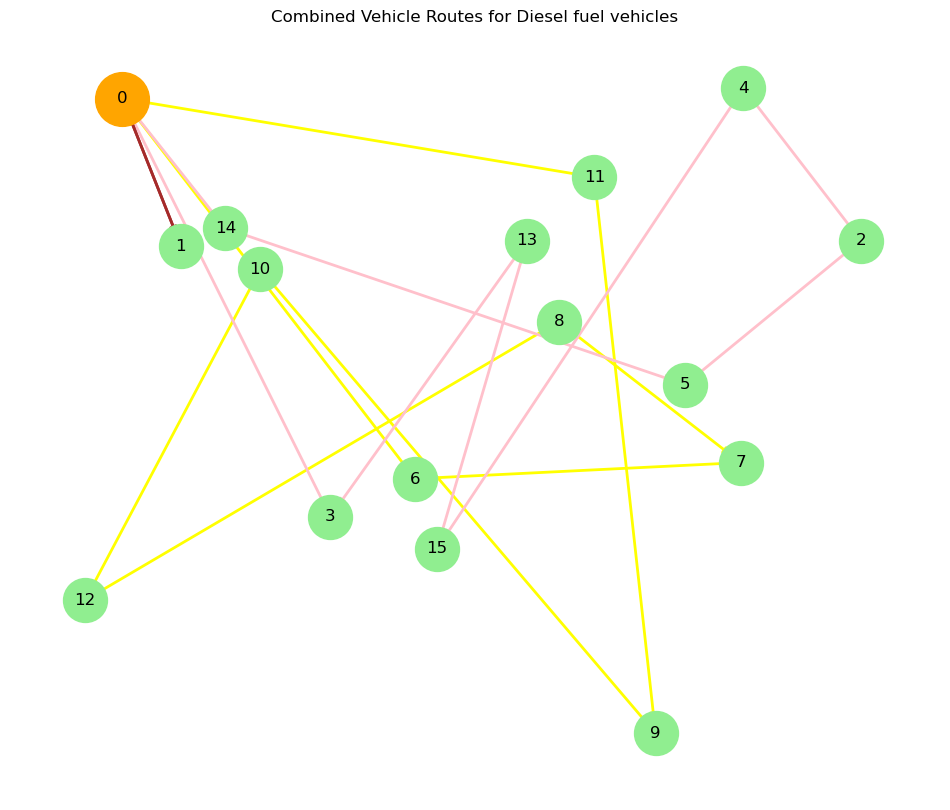

In [8]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import random

def create_data_model():
    data = {        
        'distance_matrix': [
            [0, 321, 647, 887, 492, 644, 556, 513, 825, 655, 598, 493, 774, 529, 371, 834], 
            [321, 0, 421, 661, 266, 417, 499, 682, 994, 1125, 919, 961, 1022, 303, 194, 608], 
            [647, 468, 0, 989, 380, 146, 864, 1047, 1359, 1245, 1309, 1081, 1484, 629, 314, 638], 
            [344, 665, 1134, 0, 613, 988, 426, 410, 595, 999, 901, 936, 749, 362, 675, 490],
            [492, 266, 380, 609, 0, 376, 670, 854, 1165, 1391, 1090, 1227, 1120, 251, 460, 342], 
            [540, 322, 146, 844, 376, 0, 718, 901, 1213, 1099, 1163, 935, 1339, 625, 168, 634], 
            [218, 539, 1008, 337, 710, 862, 0, 183, 495, 769, 674, 582, 522, 573, 550, 942],
            [402, 833, 1191, 410, 781, 1045, 183, 0, 312, 726, 668, 637, 480, 530, 733, 899], 
            [713, 1144, 1503, 595, 1093, 1357, 495, 312, 0, 839, 651, 635, 231, 842, 1045, 946],
            [719, 1404, 1301, 982, 1353, 1156, 755, 712, 680, 0, 121, 349, 449, 1102, 987, 1471], 
            [598, 919, 1309, 901, 1090, 1163, 674, 631, 599, 432, 0, 228, 368, 1021, 994, 1390],
            [493, 814, 1081, 936, 985, 935, 582, 637, 635, 204, 228, 0, 403, 1056, 767, 1426], 
            [767, 1152, 1484, 827, 1100, 1339, 549, 604, 231, 608, 509, 403, 0, 994, 1170, 1178], 
            [464, 303, 629, 362, 251, 626, 573, 530, 842, 1116, 1021, 1056, 869, 0, 497, 369], 
            [371, 518, 314, 675, 544, 168, 550, 733, 1045, 931, 994, 767, 1072, 795, 0, 802], 
            [834, 608, 638, 490, 342, 634, 942, 899, 946, 1485, 1390, 1426, 1239, 369, 802, 0]
        ],
            # Distance matrix as provided in previous examples
    
        'cost_per_km': [0.63, 0.64,0.65],  # Cost per mile for the three Diesel vehicles
        'emission_factor': [0.61, 1.00, 1.44],  # kg CO2 per mile for the three Diesel vehicles
        'energy_cost': [0.16, 0.18 ,0.19],  # Energy cost per mile for  three Diesel vehicles
        'demands': [0, 24, 32, 28, 13, 41, 45, 12, 10, 33, 7, 40, 30, 73, 27, 29],  # Demands at each node
        'vehicle_capacities': [250, 300, 350],  # Capacities of vehicles
        'num_vehicles': 3,  # Number of vehicles
        'depot': 0  # Index of the depot in the distance matrix
    }
    return data


def solve_vrp():
    data = create_data_model()
    prob = pulp.LpProblem("VehicleRoutingProblem", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, j, k) for i in range(len(data['distance_matrix']))
                                    for j in range(len(data['distance_matrix'])) if i != j
                                    for k in range(data['num_vehicles'])),
                              cat='Binary')

    # Define objective function and constraints here
    # Objective function (currently only minimizes distance)
    prob += pulp.lpSum([data['distance_matrix'][i][j] * x[(i, j, k)]
                        for i in range(len(data['distance_matrix']))
                        for j in range(len(data['distance_matrix'])) if i != j
                        for k in range(data['num_vehicles'])])

    # Constraints
    # ... (no changes to the constraints section, it remains as you originally provided)
    # Each location must be visited by exactly one vehicle
    for j in range(1, len(data['distance_matrix'])):  # Excluding depot
        prob += pulp.lpSum(x[(i, j, k)] for i in range(len(data['distance_matrix'])) if i != j
                           for k in range(data['num_vehicles'])) == 1

    # Each vehicle's route starts and ends at the depot, and each node must be visited
    for k in range(data['num_vehicles']):
        prob += pulp.lpSum(x[(data['depot'], j, k)] for j in range(1, len(data['distance_matrix']))) == 1
        prob += pulp.lpSum(x[(i, data['depot'], k)] for i in range(1, len(data['distance_matrix']))) == 1

    # Each vehicle must leave a location it arrives at
    for i in range(1, len(data['distance_matrix'])):
        for k in range(data['num_vehicles']):
            prob += pulp.lpSum(x[(i, j, k)] for j in range(len(data['distance_matrix'])) if j != i) - \
                    pulp.lpSum(x[(j, i, k)] for j in range(len(data['distance_matrix'])) if j != i) == 0

    # Capacity constraints for each vehicle
    for k in range(data['num_vehicles']):
        prob += pulp.lpSum(data['demands'][j] * x[(i, j, k)] for i in range(len(data['distance_matrix']))
                           for j in range(len(data['distance_matrix'])) if i != j) <= data['vehicle_capacities'][k]

   
    # Subtour Elimination
    u = pulp.LpVariable.dicts('u', range(len(data['distance_matrix'])), lowBound=0, cat='Continuous')
    for i in range(len(data['distance_matrix'])):
        for j in range(1, len(data['distance_matrix'])):
            if i != j:
                for k in range(data['num_vehicles']):
                    prob += u[i] - u[j] + len(data['distance_matrix']) * x[(i, j, k)] <= len(data['distance_matrix']) - 1


    status = prob.solve()
    print(f"Status: {pulp.LpStatus[status]}")

    # Visualization setup
    plt.figure(figsize=(12, 10))
    G = nx.DiGraph()

    # Set random seed for reproducibility
    random.seed(55)

    # Manually assign random positions to nodes
    pos = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(len(data['distance_matrix']))}

    # Add all nodes and define colors for each vehicle
    colors = ['yellow', 'pink','brown']

    for i in range(len(data['distance_matrix'])):
        G.add_node(i)

    # Draw nodes with a uniform appearance
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=1000)
    nx.draw_networkx_labels(G, pos)

    # Draw vehicle routes
    for k in range(data['num_vehicles']):
        route_edges = []
        for i in range(len(data['distance_matrix'])):
            for j in range(len(data['distance_matrix'])):
                if i != j and pulp.value(x[(i, j, k)]) == 1:
                    route_edges.append((i, j))
        
        # Draw the edges for this vehicle
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color=colors[k], width=2, style='solid', arrows=True)

    # Highlight the depot node differently
    nx.draw_networkx_nodes(G, pos, nodelist=[data['depot']], node_color='orange', node_size=1500)

    plt.title('Combined Vehicle Routes for Diesel fuel vehicles')
    plt.axis('off')  # Turn off the axis
    plt.show()

if __name__ == "__main__":
    solve_vrp()


In [9]:
pip install pulp matplotlib


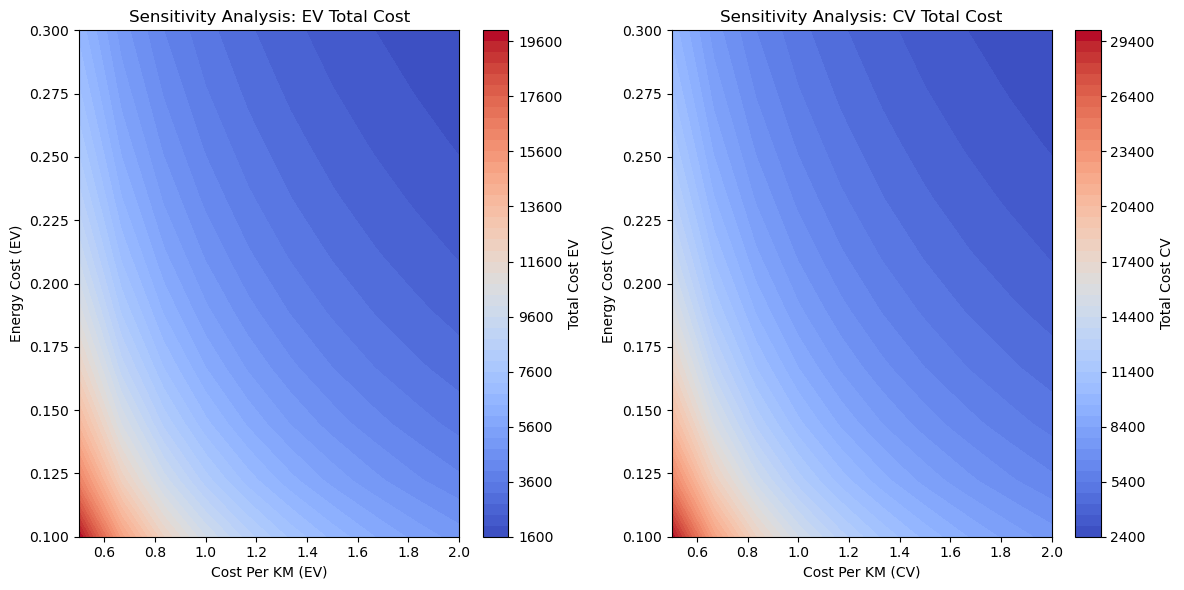

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder function for solve_vrp
def solve_vrp(cost_per_km_ev, cost_per_km_cv, energy_cost_ev, energy_cost_cv):
    # Placeholder: return dummy costs inversely proportional to the cost per km and energy cost
    total_cost_ev = 1000 / (cost_per_km_ev * energy_cost_ev)
    total_cost_cv = 1500 / (cost_per_km_cv * energy_cost_cv)
    return total_cost_ev, total_cost_cv

# Sensitivity analysis function
def sensitivity_analysis():
    # Define a range for cost per km and energy cost for sensitivity analysis
    cost_per_km_range = np.linspace(0.5, 2.0, 10)  # Cost per km
    energy_cost_range = np.linspace(0.1, 0.3, 10)  # Energy cost

    # Create a meshgrid for plotting
    X, Y = np.meshgrid(cost_per_km_range, energy_cost_range)
    Z_ev = np.zeros_like(X)
    Z_cv = np.zeros_like(X)

    # Perform analysis over the range of values and fill the Z matrix with total costs
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z_ev[i, j], Z_cv[i, j] = solve_vrp(X[i, j], X[i, j], Y[i, j], Y[i, j])

    # Plot the results for electric vehicles
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, Z_ev, cmap='coolwarm', levels=50)
    plt.colorbar(label='Total Cost EV')
    plt.title('Sensitivity Analysis: EV Total Cost')
    plt.xlabel('Cost Per KM (EV)')
    plt.ylabel('Energy Cost (EV)')

    # Plot the results for conventional vehicles
    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, Z_cv, cmap='coolwarm', levels=50)
    plt.colorbar(label='Total Cost CV')
    plt.title('Sensitivity Analysis: CV Total Cost')
    plt.xlabel('Cost Per KM (CV)')
    plt.ylabel('Energy Cost (CV)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    sensitivity_analysis()



# ELECTRIC VEHICLE

1. Modelling

In [11]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def create_data_model():
    data = {        
        'distance_matrix': [
            [0, 321, 647, 887, 492, 644, 556, 513, 825, 655, 598, 493, 774, 529, 371, 834], 
            [321, 0, 421, 661, 266, 417, 499, 682, 994, 1125, 919, 961, 1022, 303, 194, 608], 
            [647, 468, 0, 989, 380, 146, 864, 1047, 1359, 1245, 1309, 1081, 1484, 629, 314, 638], 
            [344, 665, 1134, 0, 613, 988, 426, 410, 595, 999, 901, 936, 749, 362, 675, 490],
            [492, 266, 380, 609, 0, 376, 670, 854, 1165, 1391, 1090, 1227, 1120, 251, 460, 342], 
            [540, 322, 146, 844, 376, 0, 718, 901, 1213, 1099, 1163, 935, 1339, 625, 168, 634], 
            [218, 539, 1008, 337, 710, 862, 0, 183, 495, 769, 674, 582, 522, 573, 550, 942],
            [402, 833, 1191, 410, 781, 1045, 183, 0, 312, 726, 668, 637, 480, 530, 733, 899], 
            [713, 1144, 1503, 595, 1093, 1357, 495, 312, 0, 839, 651, 635, 231, 842, 1045, 946],
            [719, 1404, 1301, 982, 1353, 1156, 755, 712, 680, 0, 121, 349, 449, 1102, 987, 1471], 
            [598, 919, 1309, 901, 1090, 1163, 674, 631, 599, 432, 0, 228, 368, 1021, 994, 1390],
            [493, 814, 1081, 936, 985, 935, 582, 637, 635, 204, 228, 0, 403, 1056, 767, 1426], 
            [767, 1152, 1484, 827, 1100, 1339, 549, 604, 231, 608, 509, 403, 0, 994, 1170, 1178], 
            [464, 303, 629, 362, 251, 626, 573, 530, 842, 1116, 1021, 1056, 869, 0, 497, 369], 
            [371, 518, 314, 675, 544, 168, 550, 733, 1045, 931, 994, 767, 1072, 795, 0, 802], 
            [834, 608, 638, 490, 342, 634, 942, 899, 946, 1485, 1390, 1426, 1239, 369, 802, 0]
        ],
            # Distance matrix as provided in previous examples
    
        'cost_per_mile': [0.58,0.59,0.60],  # Cost per mile for electric vehicles
        'emission_factor': [.246,0.164,.123],  # kg CO2 per mile for electric vehicles
        'energy_cost': [0.031, 0.035,0.044],  # Energy cost per mile for electric vehicles
        'demands': [0, 24, 32, 28, 13, 41, 45, 12, 10, 33, 7, 40, 30, 73, 27, 29],  # Demands at each node
        'vehicle_capacities': [150, 200, 250],  # Capacities of vehicles
        'num_vehicles': 3,  # Number of vehicles
        'depot': 0  # Index of the depot in the distance matrix
    }
    return data


def solve_vrp():
    data = create_data_model()
    prob = pulp.LpProblem("VehicleRoutingProblem", pulp.LpMinimize)

    # Decision variables
    x = pulp.LpVariable.dicts("x", ((i, j, k) for i in range(len(data['distance_matrix']))
                                    for j in range(len(data['distance_matrix'])) if i != j
                                    for k in range(data['num_vehicles'])),
                              cat='Binary')
    demand_variation = [random.choice([-10, -5, 0, 10, 20]) for _ in data['demands']]
    adjusted_demands = [max(0, d + v) for d, v in zip(data['demands'], demand_variation)]
    data = create_data_model()

    # Objective function with minor adjustments to the costs
    # Example: Add a slight random cost to each distance to change the routes
    prob += pulp.lpSum([(data['distance_matrix'][i][j] + random.uniform(-0.1, 0.1)) * x[(i, j, k)]
                        for i in range(len(data['distance_matrix']))
                        for j in range(len(data['distance_matrix'])) if i != j
                        for k in range(data['num_vehicles'])])

   
    # Constraints
    # ... (no changes to the constraints section, it remains as you originally provided)
    # Each location must be visited by exactly one vehicle
    for j in range(1, len(data['distance_matrix'])):  # Excluding depot
        prob += pulp.lpSum(x[(i, j, k)] for i in range(len(data['distance_matrix'])) if i != j
                           for k in range(data['num_vehicles'])) == 1

    # Each vehicle's route starts and ends at the depot, and each node must be visited
    for k in range(data['num_vehicles']):
        prob += pulp.lpSum(x[(data['depot'], j, k)] for j in range(1, len(data['distance_matrix']))) == 1
        prob += pulp.lpSum(x[(i, data['depot'], k)] for i in range(1, len(data['distance_matrix']))) == 1

    # Each vehicle must leave a location it arrives at
    for i in range(1, len(data['distance_matrix'])):
        for k in range(data['num_vehicles']):
            prob += pulp.lpSum(x[(i, j, k)] for j in range(len(data['distance_matrix'])) if j != i) - \
                    pulp.lpSum(x[(j, i, k)] for j in range(len(data['distance_matrix'])) if j != i) == 0

    # Adjust capacity constraints to consider the adjusted demands
    for k in range(data['num_vehicles']):
         prob += pulp.lpSum(adjusted_demands[j] * x[(i, j, k)] for i in range(len(data['distance_matrix']))
                       for j in range(len(data['distance_matrix'])) if i != j) <= data['vehicle_capacities'][k]


   
    # Subtour Elimination
    u = pulp.LpVariable.dicts('u', range(len(data['distance_matrix'])), lowBound=0, cat='Continuous')
    for i in range(len(data['distance_matrix'])):
        for j in range(1, len(data['distance_matrix'])):
            if i != j:
                for k in range(data['num_vehicles']):
                    prob += u[i] - u[j] + len(data['distance_matrix']) * x[(i, j, k)] <= len(data['distance_matrix']) - 1

    # Solve the problem
    status = prob.solve()
    print(f"Status: {pulp.LpStatus[status]}")

    # Prepare the graph visualization and route extraction
    G = nx.DiGraph()
    route_details = []

    for k in range(data['num_vehicles']):
        route_distance = 0
        route_cost = 0
        route_emissions = 0
        route_energy_cost = 0
        node_sequence = [data['depot']]
        edge_list = []
        node = data['depot']
        while True:
            next_nodes = [j for j in range(len(data['distance_matrix'])) if j != node and pulp.value(x[(node, j, k)]) == 1]
            if not next_nodes:
                break
            next_node = next_nodes[0]
            edge_list.append((node, next_node))

            # Distance between the two nodes
            distance = data['distance_matrix'][node][next_node]

            # Update the route distance
            route_distance += distance

            # Update the cost, emissions, and energy cost for this segment of the route
            vehicle_type_index = k % 2  # Assuming the first vehicle is electric and the second is conventional
            cost_per_mile = data['cost_per_mile'][vehicle_type_index]
            emission_factor = data['emission_factor'][vehicle_type_index]
            energy_cost_per_km = data['energy_cost'][vehicle_type_index]

            route_cost += distance * cost_per_mile
            route_emissions += distance * emission_factor
            route_energy_cost += distance * energy_cost_per_km

            node_sequence.append(next_node)
            node = next_node
            if node == data['depot']:
                break

        route_details.append({
            'vehicle_index': k,
            'distance': route_distance,
            'cost': route_cost,
            'emissions': route_emissions,
            'energy_cost': route_energy_cost,
            'route': node_sequence
        })
        G.add_edges_from(edge_list)

    # Visualization code here...

    # Print route details including total cost, emissions, and energy costs
    for details in route_details:
        route_str = ' -> '.join(map(str, details['route']))
        print(f"Vehicle {details['vehicle_index']} - Route: {route_str}, "
              f"Distance: {details['distance']}, "
              f"Total Cost: {details['cost']:.2f}, "
              f"Emissions Cost: {details['emissions']:.2f} kg CO2, "
              f"Energy Cost: {details['energy_cost']:.2f}")

if __name__ == "__main__":
    solve_vrp()



Status: Optimal
Vehicle 0 - Route: 0 -> 1 -> 13 -> 0, Distance: 1088, Total Cost: 631.04, Emissions Cost: 267.65 kg CO2, Energy Cost: 33.73
Vehicle 1 - Route: 0 -> 14 -> 5 -> 2 -> 4 -> 15 -> 3 -> 0, Distance: 2241, Total Cost: 1322.19, Emissions Cost: 367.52 kg CO2, Energy Cost: 78.44
Vehicle 2 - Route: 0 -> 11 -> 9 -> 10 -> 12 -> 8 -> 7 -> 6 -> 0, Distance: 2130, Total Cost: 1235.40, Emissions Cost: 523.98 kg CO2, Energy Cost: 66.03


2. Visualization

Status: Optimal


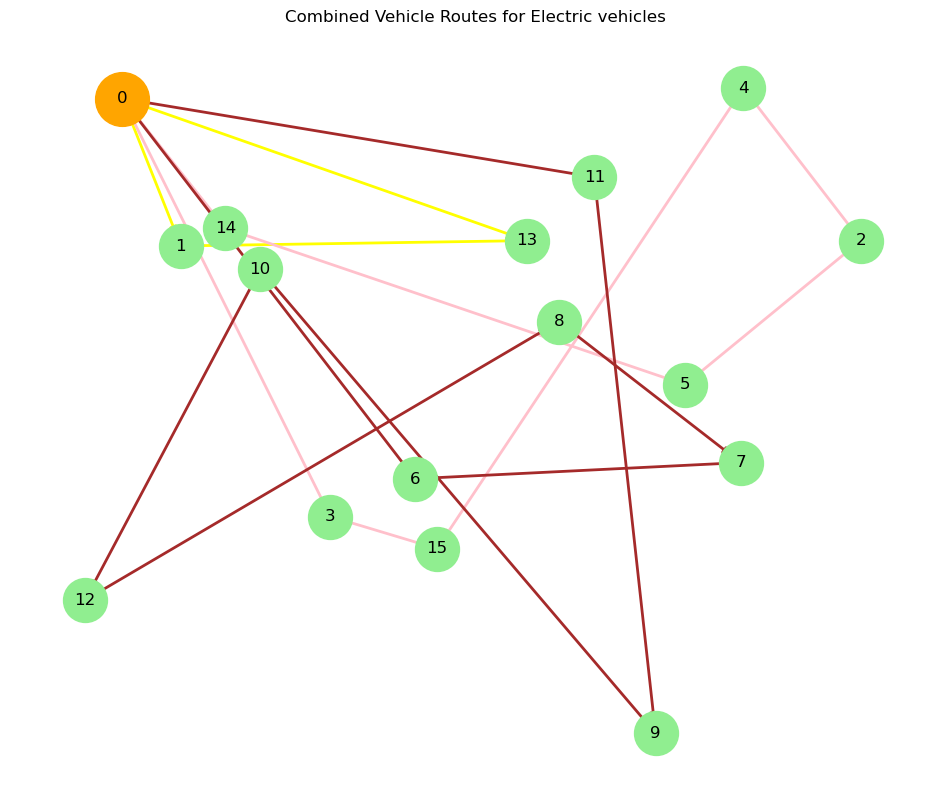

In [12]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def create_data_model():
    data = {        
        'distance_matrix': [
            [0, 321, 647, 887, 492, 644, 556, 513, 825, 655, 598, 493, 774, 529, 371, 834], 
            [321, 0, 421, 661, 266, 417, 499, 682, 994, 1125, 919, 961, 1022, 303, 194, 608], 
            [647, 468, 0, 989, 380, 146, 864, 1047, 1359, 1245, 1309, 1081, 1484, 629, 314, 638], 
            [344, 665, 1134, 0, 613, 988, 426, 410, 595, 999, 901, 936, 749, 362, 675, 490],
            [492, 266, 380, 609, 0, 376, 670, 854, 1165, 1391, 1090, 1227, 1120, 251, 460, 342], 
            [540, 322, 146, 844, 376, 0, 718, 901, 1213, 1099, 1163, 935, 1339, 625, 168, 634], 
            [218, 539, 1008, 337, 710, 862, 0, 183, 495, 769, 674, 582, 522, 573, 550, 942],
            [402, 833, 1191, 410, 781, 1045, 183, 0, 312, 726, 668, 637, 480, 530, 733, 899], 
            [713, 1144, 1503, 595, 1093, 1357, 495, 312, 0, 839, 651, 635, 231, 842, 1045, 946],
            [719, 1404, 1301, 982, 1353, 1156, 755, 712, 680, 0, 121, 349, 449, 1102, 987, 1471], 
            [598, 919, 1309, 901, 1090, 1163, 674, 631, 599, 432, 0, 228, 368, 1021, 994, 1390],
            [493, 814, 1081, 936, 985, 935, 582, 637, 635, 204, 228, 0, 403, 1056, 767, 1426], 
            [767, 1152, 1484, 827, 1100, 1339, 549, 604, 231, 608, 509, 403, 0, 994, 1170, 1178], 
            [464, 303, 629, 362, 251, 626, 573, 530, 842, 1116, 1021, 1056, 869, 0, 497, 369], 
            [371, 518, 314, 675, 544, 168, 550, 733, 1045, 931, 994, 767, 1072, 795, 0, 802], 
            [834, 608, 638, 490, 342, 634, 942, 899, 946, 1485, 1390, 1426, 1239, 369, 802, 0]
        ],
            # Distance matrix as provided in previous examples
    
        'cost_per_mile': [0.58,0.59,0.60],  # Cost per mile for electric vehicles
        'emission_factor': [.246,0.164,.123],  # kg CO2 per mile for electric vehicles
        'energy_cost': [0.031, 0.035,0.044],  # Energy cost per mile for electric vehicles
        'demands': [0, 24, 32, 28, 13, 41, 45, 12, 10, 33, 7, 40, 30, 73, 27, 29],  # Demands at each node
        'vehicle_capacities': [150, 200, 250],  # Capacities of vehicles
        'num_vehicles': 3,  # Number of vehicles
        'depot': 0  # Index of the depot in the distance matrix
    }
    return data

def solve_vrp():
    data = create_data_model()
    prob = pulp.LpProblem("VehicleRoutingProblem", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, j, k) for i in range(len(data['distance_matrix']))
                                    for j in range(len(data['distance_matrix'])) if i != j
                                    for k in range(data['num_vehicles'])),
                              cat='Binary')   
    demand_variation = [random.choice([-10, -5, 0, 10, 20]) for _ in data['demands']]
    adjusted_demands = [max(0, d + v) for d, v in zip(data['demands'], demand_variation)]
    data = create_data_model()

    # Objective function with minor adjustments to the costs
    # Example: Add a slight random cost to each distance to change the routes
    prob += pulp.lpSum([(data['distance_matrix'][i][j] + random.uniform(-0.1, 0.1)) * x[(i, j, k)]
                        for i in range(len(data['distance_matrix']))
                        for j in range(len(data['distance_matrix'])) if i != j
                        for k in range(data['num_vehicles'])])


    # Constraints
    # ... (no changes to the constraints section, it remains as you originally provided)
    # Each location must be visited by exactly one vehicle
    for j in range(1, len(data['distance_matrix'])):  # Excluding depot
        prob += pulp.lpSum(x[(i, j, k)] for i in range(len(data['distance_matrix'])) if i != j
                           for k in range(data['num_vehicles'])) == 1

    # Each vehicle's route starts and ends at the depot, and each node must be visited
    for k in range(data['num_vehicles']):
        prob += pulp.lpSum(x[(data['depot'], j, k)] for j in range(1, len(data['distance_matrix']))) == 1
        prob += pulp.lpSum(x[(i, data['depot'], k)] for i in range(1, len(data['distance_matrix']))) == 1

    # Each vehicle must leave a location it arrives at
    for i in range(1, len(data['distance_matrix'])):
        for k in range(data['num_vehicles']):
            prob += pulp.lpSum(x[(i, j, k)] for j in range(len(data['distance_matrix'])) if j != i) - \
                    pulp.lpSum(x[(j, i, k)] for j in range(len(data['distance_matrix'])) if j != i) == 0

    # Adjust capacity constraints to consider the adjusted demands
    for k in range(data['num_vehicles']):
         prob += pulp.lpSum(adjusted_demands[j] * x[(i, j, k)] for i in range(len(data['distance_matrix']))
                       for j in range(len(data['distance_matrix'])) if i != j) <= data['vehicle_capacities'][k]


    
    
   
    # Subtour Elimination
    u = pulp.LpVariable.dicts('u', range(len(data['distance_matrix'])), lowBound=0, cat='Continuous')
    for i in range(len(data['distance_matrix'])):
        for j in range(1, len(data['distance_matrix'])):
            if i != j:
                for k in range(data['num_vehicles']):
                    prob += u[i] - u[j] + len(data['distance_matrix']) * x[(i, j, k)] <= len(data['distance_matrix']) - 1


    status = prob.solve()
    print(f"Status: {pulp.LpStatus[status]}")

    # Visualization setup
    plt.figure(figsize=(12, 10))
    G = nx.DiGraph()

    # Set random seed for reproducibility
    random.seed(55)

    # Manually assign random positions to nodes
    pos = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(len(data['distance_matrix']))}

    # Add all nodes and define colors for each vehicle
    colors = ['yellow', 'pink','brown']

    for i in range(len(data['distance_matrix'])):
        G.add_node(i)

    # Draw nodes with a uniform appearance
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=1000)
    nx.draw_networkx_labels(G, pos)

    # Draw vehicle routes
    for k in range(data['num_vehicles']):
        route_edges = []
        for i in range(len(data['distance_matrix'])):
            for j in range(len(data['distance_matrix'])):
                if i != j and pulp.value(x[(i, j, k)]) == 1:
                    route_edges.append((i, j))
        
        # Draw the edges for this vehicle
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color=colors[k], width=2, style='solid', arrows=True)

    # Highlight the depot node differently
    nx.draw_networkx_nodes(G, pos, nodelist=[data['depot']], node_color='orange', node_size=1500)

    plt.title('Combined Vehicle Routes for Electric vehicles')
    plt.axis('off')  # Turn off the axis
    plt.show()

if __name__ == "__main__":
     solve_vrp()

3.Scenario Analysis

In [13]:
import seaborn as sns

C:\Users\shami\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


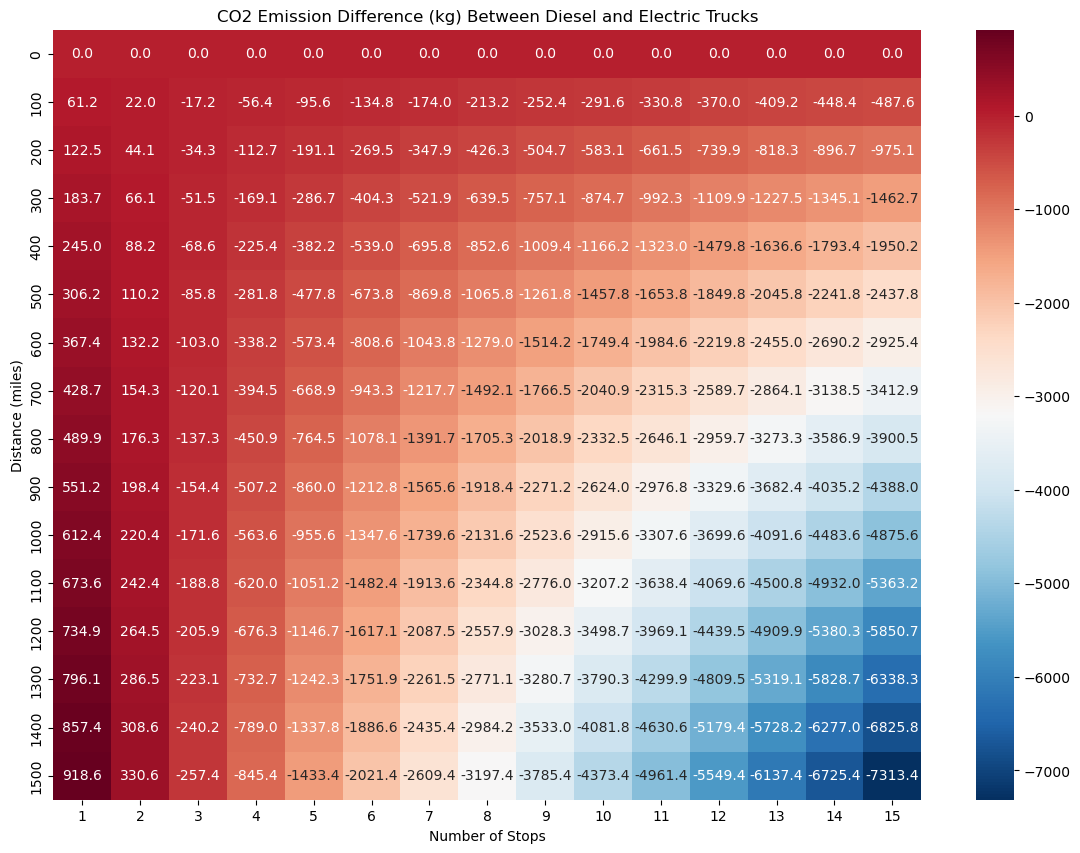

In [14]:
# Constants based on user provided data
diesel_fuel_efficiency = 15 # miles per gallon for heavy-duty trucks
diesel_CO2_per_liter =3.98# kg of CO2 per liter of diesel consumed
liters_per_gallon = 3.78541  # conversion factor from gallons to liters
electric_energy_consumption = 0.8 # kWh per mile for heavy-duty electric trucks
electric_emissions_factor = 0.49  # kg of CO2 per kWh

# Convert diesel CO2 emissions to per mile
diesel_CO2_per_mile = (diesel_CO2_per_liter * liters_per_gallon) / diesel_fuel_efficiency

# For electric trucks, the emissions per mile is direct multiplication
electric_CO2_per_mile = electric_energy_consumption * electric_emissions_factor

# Define distances (0 to 1500 miles) and number of stops (recipients)
distances = np.arange(0, 1501, 100)  # 0 to 300 miles
stops = np.arange(1, 16)  # 1 to 15 stops

# Create a matrix to hold the emission difference values
emission_diff_matrix = np.zeros((len(distances), len(stops)))

# Calculate the emissions for each distance and number of stops for diesel and electric vehicles
for i, distance in enumerate(distances):
    for j, stop in enumerate(stops):
        diesel_emissions = distance * diesel_CO2_per_mile
        electric_emissions = distance * electric_CO2_per_mile
        # Since we are considering a single delivery per trip for electric trucks, we multiply stops
        electric_emissions *= stop
        # The difference in emissions is then diesel minus electric
        emission_diff_matrix[i, j] = diesel_emissions - electric_emissions

# Generating the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(emission_diff_matrix, annot=True, cmap="RdBu_r", fmt=".1f",
                 xticklabels=stops, yticklabels=distances)
ax.set_xlabel('Number of Stops')
ax.set_ylabel('Distance (miles)')
ax.set_title('CO2 Emission Difference (kg) Between Diesel and Electric Trucks')
plt.show()


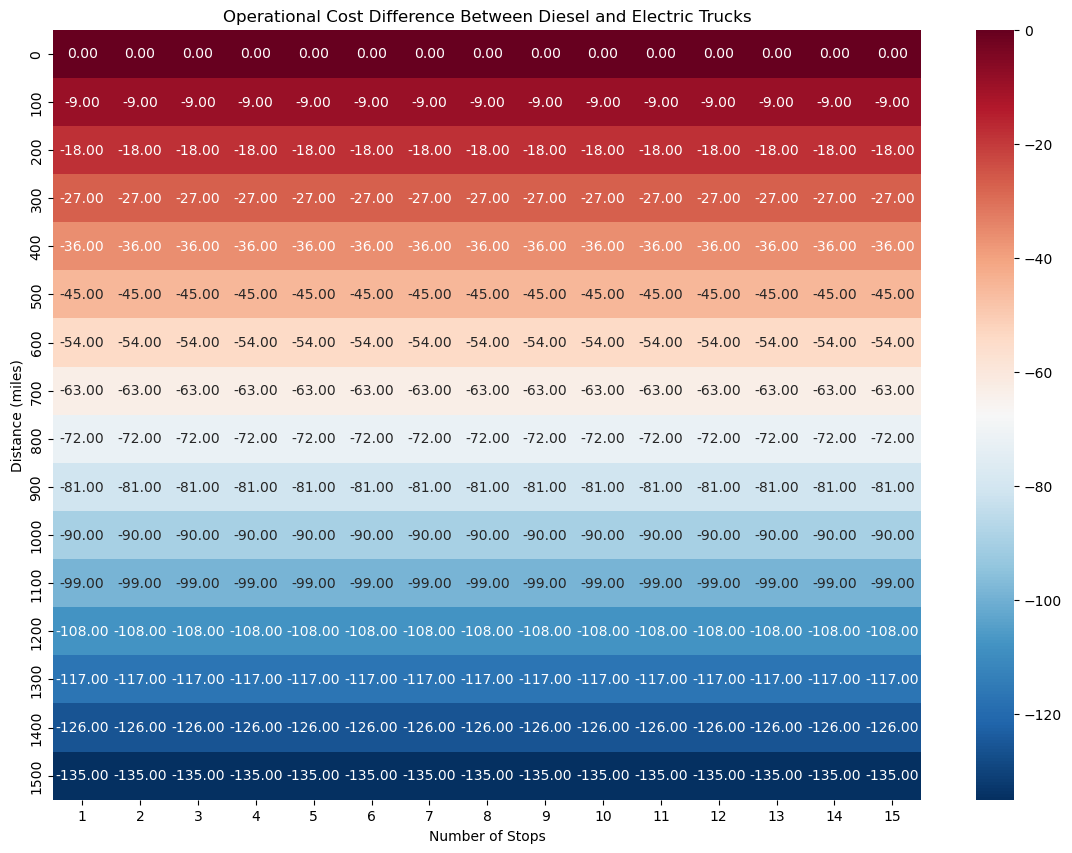

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants based on user-provided data
diesel_cost_per_mile = 0.68  # Example cost per mile for diesel trucks
electric_cost_per_mile = 0.59 # Example cost per mile for electric trucks

# Define distances (in miles) and number of stops (recipients)
distances = np.arange(0, 1501, 100)  # Distances from 0 to 1500 miles with a step of 100
stops = np.arange(1, 16)  # Stops from 1 to 15

# Create a matrix to hold the operational cost values
operational_cost_matrix = np.zeros((len(distances), len(stops)))

# Calculate the operational costs for each distance and number of stops for diesel and electric vehicles
for i, distance in enumerate(distances):
    for j, stop in enumerate(stops):
        diesel_operational_cost = distance * diesel_cost_per_mile
        electric_operational_cost = distance * electric_cost_per_mile
        # Since the cost is per trip, we do not multiply by stops for this example
        # The difference in operational costs is electric minus diesel
        operational_cost_matrix[i, j] = electric_operational_cost - diesel_operational_cost

# Generating the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(operational_cost_matrix, annot=True, cmap="RdBu_r", fmt=".2f",
                 xticklabels=stops, yticklabels=distances)
ax.set_xlabel('Number of Stops')
ax.set_ylabel('Distance (miles)')
ax.set_title('Operational Cost Difference Between Diesel and Electric Trucks')
plt.show()


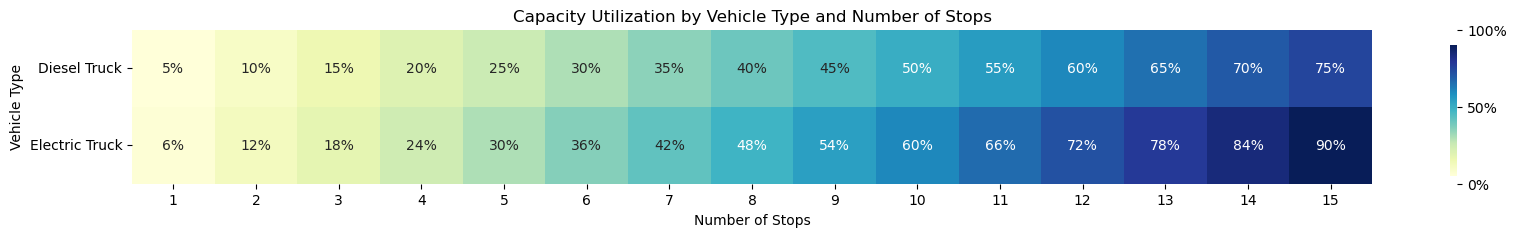

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Constants
diesel_truck_capacity = 300  # in pounds or kilograms
electric_truck_capacity = 250  # in pounds or kilograms
average_package_weight = 15 # in pounds or kilograms

# Define the range for number of stops
stops = np.arange(1, 16)  # 1 to 50 stops

# Create a matrix to hold the capacity utilization values
capacity_utilization_matrix = np.zeros((2, len(stops)))

# Calculate the capacity utilization for each number of stops for diesel and electric vehicles
for j, stop in enumerate(stops):
    total_load = stop * average_package_weight
    diesel_utilization = total_load / diesel_truck_capacity
    electric_utilization = total_load / electric_truck_capacity
    
    # Cap the utilization at 100% for visualization
    capacity_utilization_matrix[0, j] = min(1, diesel_utilization)
    capacity_utilization_matrix[1, j] = min(1, electric_utilization)

# Vehicle types
vehicle_types = ['Diesel Truck', 'Electric Truck']

# Generate the heatmap
plt.figure(figsize=(20, 2))
ax = sns.heatmap(capacity_utilization_matrix, annot=True, cmap="YlGnBu", fmt=".0%",
                 xticklabels=stops, yticklabels=vehicle_types)

# Create a colorbar with percentage
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 0.5, 1])
colorbar.set_ticklabels(['0%', '50%', '100%'])
colorbar.ax.yaxis.set_major_formatter(PercentFormatter(1))

ax.set_xlabel('Number of Stops')
ax.set_ylabel('Vehicle Type')
ax.set_title('Capacity Utilization by Vehicle Type and Number of Stops')
plt.show()




4.Sensitivity Analysis

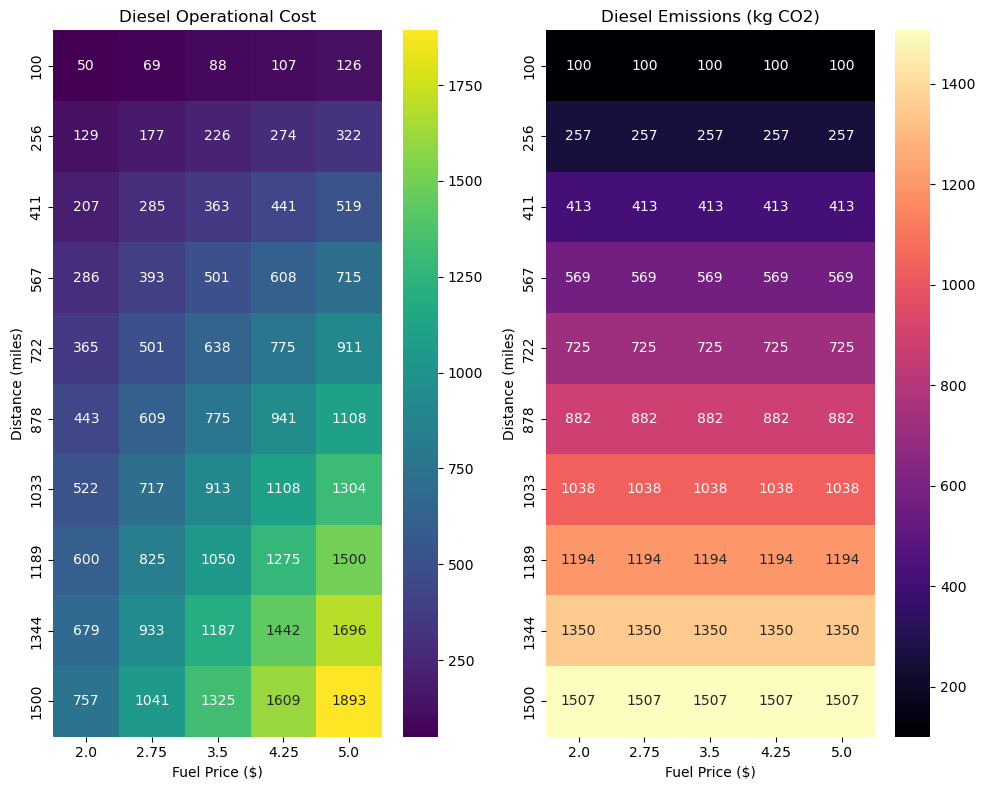

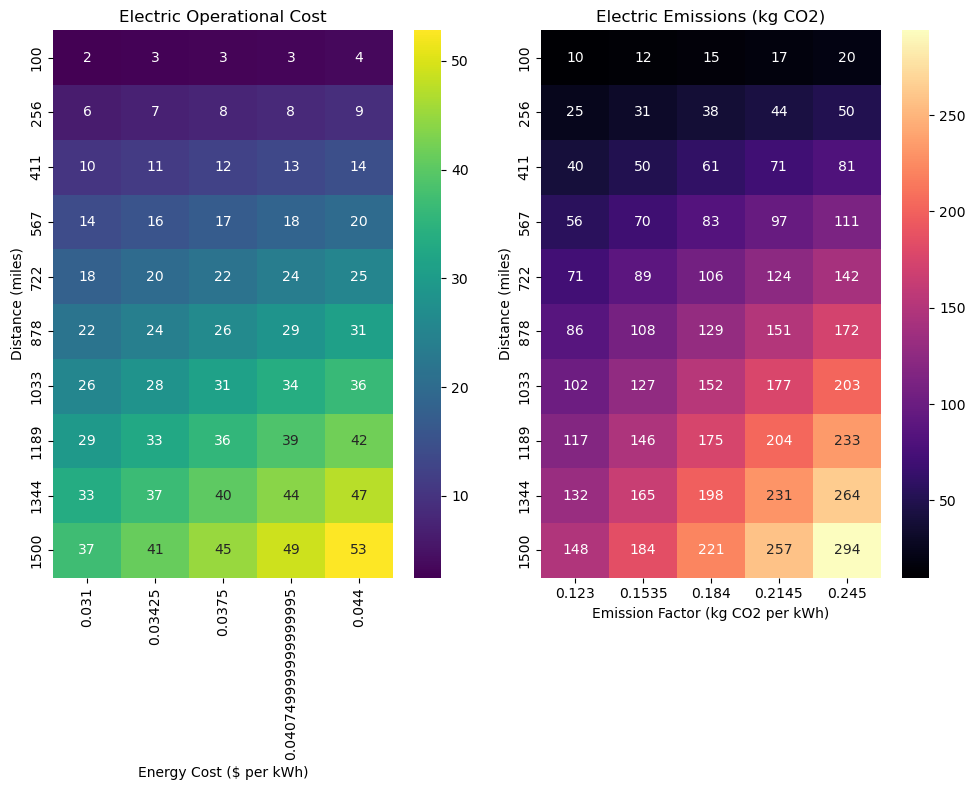

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the model outcomes for operational cost and emissions
def model_outcome(vehicle_type, distance, fuel_price=None, energy_cost=None, emission_factor=None):
    if vehicle_type == 'diesel':
        fuel_efficiency = 15  # miles per gallon for heavy-duty trucks
        diesel_CO2_per_liter = 3.98  # kg of CO2 per liter of diesel consumed
        liters_per_gallon = 3.78541  # conversion factor from gallons to liters
        # Operational cost
        gallons_needed = distance / fuel_efficiency
        cost = gallons_needed * liters_per_gallon * fuel_price
        # Emissions
        emissions = gallons_needed * liters_per_gallon * diesel_CO2_per_liter
    elif vehicle_type == 'electric':
        electric_energy_consumption = 0.8 # kWh per mile for heavy-duty electric trucks
        # Operational cost
        cost = distance * electric_energy_consumption * energy_cost
        # Emissions
        emissions = distance * electric_energy_consumption * emission_factor
    else:
        raise ValueError('Invalid vehicle type specified.')
    
    return cost, emissions

# Parameters for sensitivity analysis
distances = np.linspace(100, 1500, 10)  # For example, 100 to 1500 miles
fuel_prices = np.linspace(2, 5, 5)  # For example, $2 to $5 per liter for diesel
energy_costs = np.linspace(0.031, 0.044, 5)  # For example, $0.031to $ 5 per kWh for electric
emission_factors = np.linspace(0.123, 0.245, 5)  # For electric vehicle emissions

# Perform sensitivity analysis
results = {'diesel': {'cost': [], 'emissions': []},
           'electric': {'cost': [], 'emissions': []}}

for distance in distances:
    for fuel_price in fuel_prices:
        cost, emissions = model_outcome('diesel', distance, fuel_price=fuel_price)
        results['diesel']['cost'].append(cost)
        results['diesel']['emissions'].append(emissions)
    
    for energy_cost, emission_factor in zip(energy_costs, emission_factors):
        cost, emissions = model_outcome('electric', distance, energy_cost=energy_cost, emission_factor=emission_factor)
        results['electric']['cost'].append(cost)
        results['electric']['emissions'].append(emissions)

# Convert lists to NumPy arrays for plotting
for vehicle_type in results:
    for key in results[vehicle_type]:
        results[vehicle_type][key] = np.array(results[vehicle_type][key]).reshape(len(distances), -1)

# Create heatmaps
for vehicle_type in results:
    plt.figure(figsize=(10, 8))
    
    # Operational cost heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(results[vehicle_type]['cost'], annot=True, fmt=".0f", cmap='viridis',
                xticklabels=fuel_prices if vehicle_type == 'diesel' else energy_costs,
                yticklabels=np.round(distances).astype(int))
    plt.title(f'{vehicle_type.capitalize()} Operational Cost')
    plt.xlabel('Fuel Price ($)' if vehicle_type == 'diesel' else 'Energy Cost ($ per kWh)')
    plt.ylabel('Distance (miles)')
    
    # Emissions heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(results[vehicle_type]['emissions'], annot=True, fmt=".0f", cmap='magma',
                xticklabels=fuel_prices if vehicle_type == 'diesel' else emission_factors,
                yticklabels=np.round(distances).astype(int))
    plt.title(f'{vehicle_type.capitalize()} Emissions (kg CO2)')
    plt.xlabel('Fuel Price ($)' if vehicle_type == 'diesel' else 'Emission Factor (kg CO2 per kWh)')
    plt.ylabel('Distance (miles)')
    
    plt.tight_layout()
    plt.show()

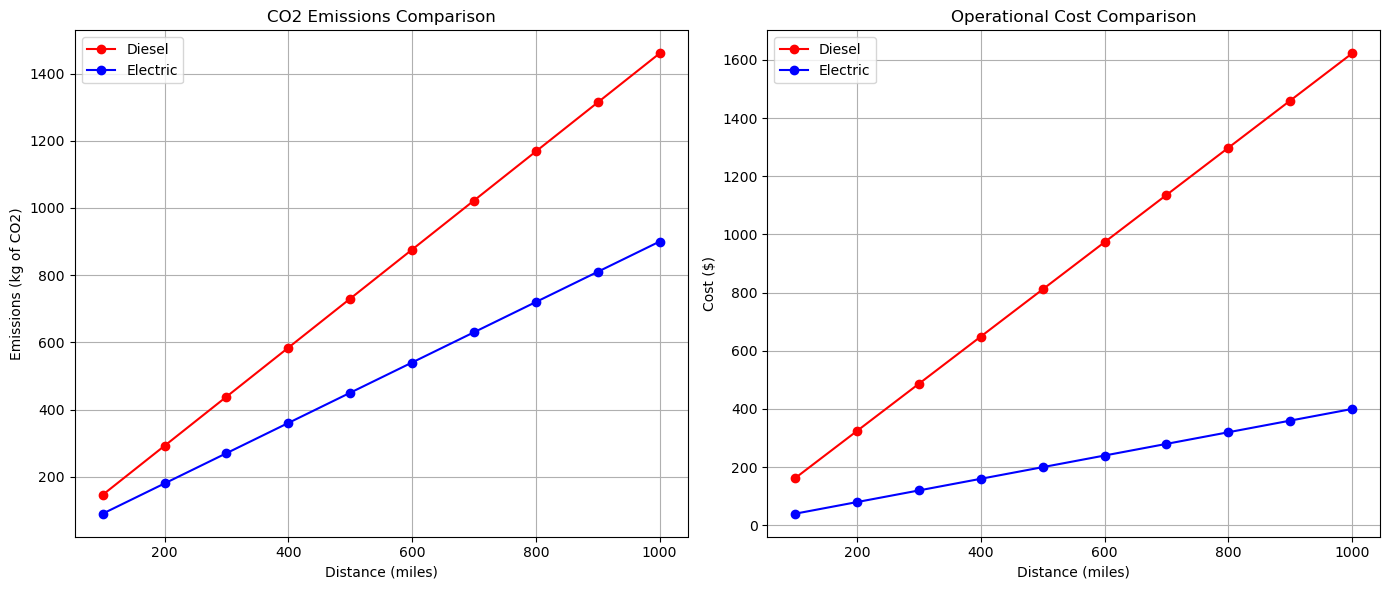

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the model outcomes for operational cost and emissions
def model_outcome(vehicle_type, distance, fuel_price=None, energy_cost=None, emission_factor=None):
    if vehicle_type == 'diesel':
        fuel_efficiency = 7  # miles per gallon for heavy-duty trucks
        diesel_CO2_per_liter = 2.7  # kg of CO2 per liter of diesel consumed
        liters_per_gallon = 3.78541  # conversion factor from gallons to liters
        # Operational cost
        gallons_needed = distance / fuel_efficiency
        cost = gallons_needed * liters_per_gallon * fuel_price
        # Emissions
        emissions = gallons_needed * liters_per_gallon * diesel_CO2_per_liter
    elif vehicle_type == 'electric':
        electric_energy_consumption = 2.0  # kWh per mile for heavy-duty electric trucks
        # Operational cost
        cost = distance * electric_energy_consumption * energy_cost
        # Emissions
        emissions = distance * electric_energy_consumption * emission_factor
    else:
        raise ValueError('Invalid vehicle type specified.')
    
    return cost, emissions

# Parameters for sensitivity analysis
distances = np.linspace(100, 1000, 10)  # For example, 100 to 1000 miles
fuel_prices = np.linspace(1, 5, 5)  # For example, $1 to $5 per liter for diesel
energy_costs = np.linspace(0.1, 0.3, 5)  # For example, $0.1 to $0.3 per kWh for electric
emission_factors = np.linspace(0.2, 0.7, 5)  # For electric vehicle emissions

# Perform sensitivity analysis and store results
results = {'diesel': {'cost': [], 'emissions': []},
           'electric': {'cost': [], 'emissions': []}}

for distance in distances:
    # Assume mid-point prices for simplicity in line plot
    fuel_price = np.mean(fuel_prices)
    energy_cost = np.mean(energy_costs)
    emission_factor = np.mean(emission_factors)
    
    cost, emissions = model_outcome('diesel', distance, fuel_price=fuel_price)
    results['diesel']['cost'].append(cost)
    results['diesel']['emissions'].append(emissions)
    
    cost, emissions = model_outcome('electric', distance, energy_cost=energy_cost, emission_factor=emission_factor)
    results['electric']['cost'].append(cost)
    results['electric']['emissions'].append(emissions)

# Line charts for emissions and operational costs
plt.figure(figsize=(14, 6))

# Emissions comparison line chart
plt.subplot(1, 2, 1)
plt.plot(distances, results['diesel']['emissions'], label='Diesel', color='red', marker='o')
plt.plot(distances, results['electric']['emissions'], label='Electric', color='blue', marker='o')
plt.title('CO2 Emissions Comparison')
plt.xlabel('Distance (miles)')
plt.ylabel('Emissions (kg of CO2)')
plt.legend()
plt.grid(True)

# Operational cost comparison line chart
plt.subplot(1, 2, 2)
plt.plot(distances, results['diesel']['cost'], label='Diesel', color='red', marker='o')
plt.plot(distances, results['electric']['cost'], label='Electric', color='blue', marker='o')
plt.title('Operational Cost Comparison')
plt.xlabel('Distance (miles)')
plt.ylabel('Cost ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


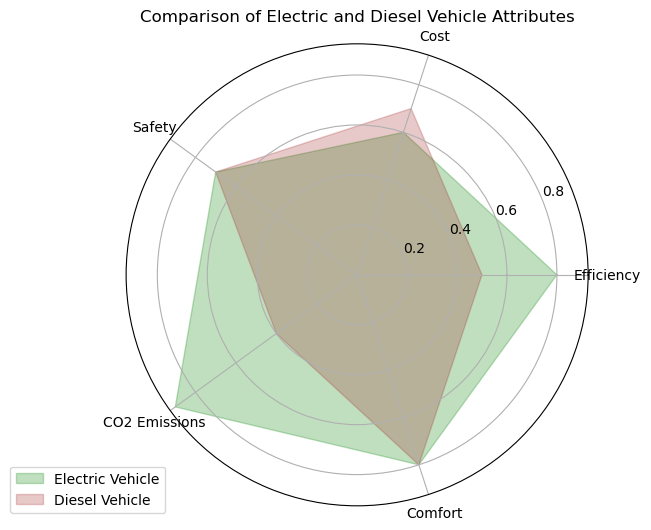

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and stats for electric and diesel vehicles
labels=np.array(['Efficiency', 'Cost', 'Safety', 'CO2 Emissions', 'Comfort'])
electric_stats=np.array([80, 60, 70, 90, 80])
diesel_stats=np.array([50, 70, 70, 40, 80])

# Ensure stats are in percentage for radar chart comparison
electric_stats = electric_stats / 100.0
diesel_stats = diesel_stats / 100.0

# Compute angles for the radar chart
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
electric_stats=np.concatenate((electric_stats,[electric_stats[0]]))
diesel_stats=np.concatenate((diesel_stats,[diesel_stats[0]]))
angles += angles[:1]

# Create a polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, electric_stats, color='green', alpha=0.25)
ax.fill(angles, diesel_stats, color='brown', alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add a legend and title for clarity
ax.legend(['Electric Vehicle', 'Diesel Vehicle'], loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax.set_title('Comparison of Electric and Diesel Vehicle Attributes')

plt.show()
